<a href="https://colab.research.google.com/github/berniehans/MIA203Grupo2/blob/main/Proyecto_Final_Grupo_2_REDES_NEURONALES_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO FINAL

# CURSO: REDES NEURONALES Y APRENDIZAJE PROFUNDO (MIA-203)

# PROFESOR: ALDO CAMARGO

# TEMA: SISTEMA DE IDENTIFICACION DE MEDIDAS CORPORALES A TRAVÉS DE IMAGENES USANDO CNN

#Grupo #2:
#Integrantes:
#- Benitez Altamirano, Bernie Hans
#- Diaz Cabrera, Alexander Gabriel
#- Morales Ccasa, Geyson David
#- Ramirez Ucañay, Barbarita Paula Janeth
#- Aldo Daniel Siu Siu Ting

##Paso #1: Importar y activar librerias

In [1]:
!pip install tensorflow
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from google.colab.patches import cv2_imshow  # Importa cv2_imshow desde google.colab.patches
from PIL import Image
from skimage import io  # Importar la función io de skimage
from sklearn.metrics import mean_absolute_error, mean_squared_error

##Paso #3: Conectar a base de datos en Google Drive

In [3]:
import os
import zipfile

# Path to your zip file
zip_path = '/content/BodyM_dataset.zip'  # Update this path

# Extraction path
extract_path = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Define the original folder name and the new folder name
old_folder_name = '/content/AWS BodyM DATASET'
new_folder_name = '/content/BodyM_dataset'

# Check if the folder exists, then rename it
if os.path.exists(old_folder_name):
    os.rename(old_folder_name, new_folder_name)


# Paso #4: Ver estructura de datos

In [4]:
# Base directory
base_dir = '/content/BodyM_dataset'

# Train data paths
train_dir = f'{base_dir}/train'
train_subject_to_photo_map = f'{train_dir}/subject_to_photo_map.csv'
train_hwg_metadata = f'{train_dir}/hwg_metadata.csv'
train_measurements = f'{train_dir}/measurements.csv'
train_mask_dir = f'{train_dir}/mask'
train_mask_left_dir = f'{train_dir}/mask_left'

# TestA data paths
testA_dir = f'{base_dir}/testA'
testA_subject_to_photo_map = f'{testA_dir}/subject_to_photo_map.csv'
testA_hwg_metadata = f'{testA_dir}/hwg_metadata.csv'
testA_measurements = f'{testA_dir}/measurements.csv'
testA_mask_dir = f'{testA_dir}/mask'
testA_mask_left_dir = f'{testA_dir}/mask_left'

# TestB data paths
testB_dir = f'{base_dir}/testB'
testB_subject_to_photo_map = f'{testB_dir}/subject_to_photo_map.csv'
testB_hwg_metadata = f'{testB_dir}/hwg_metadata.csv'
testB_measurements = f'{testB_dir}/measurements.csv'
testB_mask_dir = f'{testB_dir}/mask'
testB_mask_left_dir = f'{testB_dir}/mask_left'

In [5]:
# Load train data CSVs
train_subject_to_photo_df = pd.read_csv(train_subject_to_photo_map)
train_hwg_metadata_df = pd.read_csv(train_hwg_metadata)
train_measurements_df = pd.read_csv(train_measurements)

# Load testA data CSVs
testA_subject_to_photo_df = pd.read_csv(testA_subject_to_photo_map)
testA_hwg_metadata_df = pd.read_csv(testA_hwg_metadata)
testA_measurements_df = pd.read_csv(testA_measurements)

# Load testB data CSVs
testB_subject_to_photo_df = pd.read_csv(testB_subject_to_photo_map)
testB_hwg_metadata_df = pd.read_csv(testB_hwg_metadata)
testB_measurements_df = pd.read_csv(testB_measurements)

In [6]:
# Merge data on 'subject_id' to get photo_id, height, weight, and body measurements in one DataFrame
train_data = train_subject_to_photo_df.merge(train_hwg_metadata_df, on='subject_id').merge(train_measurements_df, on='subject_id')

In [7]:
# Define paths for images using Google Drive paths
train_data['frontal_image_path'] = train_mask_dir + '/' + train_data['photo_id'] + '.png'
train_data['lateral_image_path'] = train_mask_left_dir + '/' + train_data['photo_id'] + '.png'

# Define additional inputs and target labels
additional_inputs = train_data[['height_cm', 'weight_kg']].values  # height and weight
target_labels = train_data[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                            'height', 'hip', 'leg-length', 'shoulder-breadth',
                            'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Concatenate, Flatten, Input, Lambda
from tensorflow.keras.models import Sequential, Model

# Registrar las capas personalizadas para que puedan serializarse
@tf.keras.utils.register_keras_serializable()
class ExpandDimsLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.expand_dims(inputs, axis=1)

@tf.keras.utils.register_keras_serializable()
class TileLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(TileLayer, self).__init__(**kwargs)
        self.seq_len = seq_len

    def call(self, inputs):
        return tf.tile(inputs, [1, self.seq_len, 1])

    def get_config(self):
        config = super().get_config()
        config.update({"seq_len": self.seq_len})
        return config

@tf.keras.utils.register_keras_serializable()
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerEncoderLayer, self).__init__(**kwargs)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.att.key_dim,
            "num_heads": self.att.num_heads,
            "ff_dim": self.ffn.layers[0].units,  # Acceso a la capa interna
            "rate": self.dropout1.rate
        })
        return config

# Parámetros ajustados para el Transformer
embed_dim = 256  # Tamaño de embedding reducido
num_heads = 4    # Número de cabezas de atención
ff_dim = 256     # Tamaño de la capa oculta en la red feed-forward

# 1. Modelo modificado con capas de normalización y dropout ajustado
image_input = Input(shape=(224, 224, 2))
resnet_base = ResNet50(include_top=False, weights=None, input_tensor=image_input)
x = Flatten()(resnet_base.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Características adicionales
additional_input = Input(shape=(2,))
y = Dense(32, activation='relu')(additional_input)
y = BatchNormalization()(y)

# Combinación de características de imagen y adicionales
combined = Concatenate()([x, y])
combined = Dense(embed_dim, activation="relu")(combined)
combined = BatchNormalization()(combined)
combined = Dropout(0.2)(combined)

# Transformer y salida
combined = ExpandDimsLayer()(combined)
combined = TileLayer(2)(combined) #duplicar vector

for _ in range(2):  #capas de transformer
    transformer_layer = TransformerEncoderLayer(embed_dim, num_heads, ff_dim, rate=0.2)
    combined = transformer_layer(combined, training=True)

combined = Flatten()(combined)
z = Dense(256, activation='relu')(combined)
z = BatchNormalization()(z)
z = Dropout(0.2)(z)
output = Dense(14, activation='linear')(z)

# Definir el modelo final
model = Model(inputs=[image_input, additional_input], outputs=output)

# Scheduler y optimización ajustada
initial_learning_rate = 0.0005
optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

# Callbacks mejorados
early_stop = EarlyStopping(monitor='mae', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=25, min_lr=1e-6)

batch_size = 32
def data_generator(data, batch_size=batch_size, target_size=(224, 224)):
    while True:
        for start in range(0, len(data), batch_size):
            end = min(start + batch_size, len(data))
            batch_data = data[start:end]

            images = []
            additional_inputs = []
            labels = []

            for _, row in batch_data.iterrows():
                if os.path.exists(row['frontal_image_path']) and os.path.exists(row['lateral_image_path']):
                    # Cargar y procesar las imágenes frontal y lateral
                    frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=target_size, color_mode='grayscale')
                    lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=target_size, color_mode='grayscale')

                    # Convertir a arrays y concatenar en un input de 2 canales
                    frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
                    lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
                    combined_image = np.concatenate([frontal_image, lateral_image], axis=-1)
                    images.append(combined_image / 255.0)  # Normalizar a [0, 1]

                    # Agregar height y weight como entradas adicionales
                    additional_inputs.append([row['height_cm'], row['weight_kg']])

                    # Convertir etiquetas a float32 y agregar a la lista de labels
                    label = np.array(row[['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
                                          'height', 'hip', 'leg-length', 'shoulder-breadth',
                                          'shoulder-to-crotch', 'thigh', 'waist', 'wrist']].values, dtype=np.float32)
                    labels.append(label)

            # Convertir listas a arrays de float32 y luego a tensores
            images = tf.convert_to_tensor(np.array(images, dtype=np.float32))
            additional_inputs = tf.convert_to_tensor(np.array(additional_inputs, dtype=np.float32))
            labels = tf.convert_to_tensor(np.array(labels, dtype=np.float32))

            # La salida ahora es una tupla de tuplas
            yield (images, additional_inputs), labels

# Especifica la firma de salida del generador para que coincida con los tipos producidos
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 2), dtype=tf.float32),  # Para imágenes con 2 canales
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)             # Para height y weight
    ),
    tf.TensorSpec(shape=(None, 14), dtype=tf.float32)                # Para las etiquetas
)


In [11]:
sample_data = next(data_generator(train_data, batch_size=batch_size))
print("Images batch shape:", sample_data[0][0].shape)
print("Additional inputs batch shape:", sample_data[0][1].shape)
print("Labels batch shape:", sample_data[1].shape)


Images batch shape: (32, 224, 224, 2)
Additional inputs batch shape: (32, 2)
Labels batch shape: (32, 14)


In [17]:
# Crea el dataset desde el generador
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_data, batch_size=batch_size),
    output_signature=output_signature
)

# Entrenar el modelo usando el dataset
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=500,
    callbacks=[reduce_lr, early_stop]
)
model.save("model_1.keras")

Epoch 1/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 97s 161ms/step - loss: 5758.8423 - mae: 63.4166 - learning_rate: 5.0000e-04
Epoch 2/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 160ms/step - loss: 5255.8516 - mae: 59.6698 - learning_rate: 5.0000e-04
Epoch 3/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - loss: 3785.5447 - mae: 46.6632 - learning_rate: 5.0000e-04
Epoch 4/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - loss: 2160.3472 - mae: 30.3790 - learning_rate: 5.0000e-04
Epoch 5/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - loss: 1073.6283 - mae: 18.6701 - learning_rate: 5.0000e-04
Epoch 6/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - loss: 508.4551 - mae: 11.5870 - learning_rate: 5.0000e-04
Epoch 7/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - loss: 247.9793 - mae: 7.9727 - learning_rate: 5.0000e-04
Epoch 8/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - loss: 133.1003 - mae: 6.4008 - learning_rate: 5.0000e-04
Epoch 9/500
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - loss: 78.66

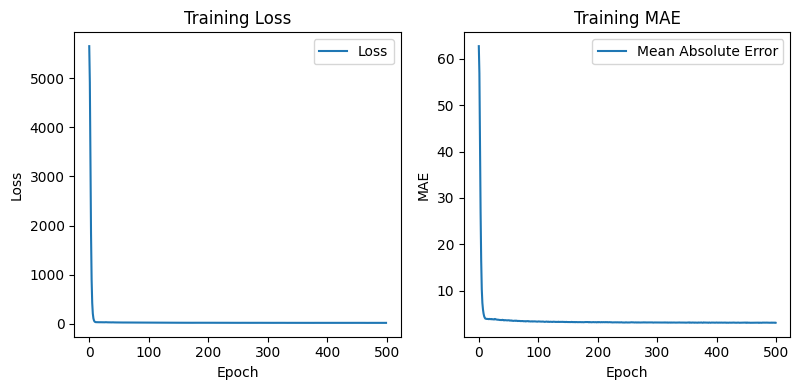

In [18]:
def custom_accuracy(y_true, y_pred, tolerance=0.1):
    # Calculate the absolute difference between predictions and true values
    diff = tf.abs(y_true - y_pred)
    # Check if the difference is within the tolerance level for each prediction
    within_tolerance = tf.less_equal(diff, tolerance * y_true)
    # Calculate mean accuracy across all dimensions
    return tf.reduce_mean(tf.cast(within_tolerance, tf.float32))

# Compile model with the custom accuracy metric
model.compile(optimizer='adam', loss='mse', metrics=['mae', custom_accuracy])

import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot mean absolute error (MAE)
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training MAE')
plt.legend()

# Plot custom accuracy (if defined)
if 'custom_accuracy' in history.history:
    plt.subplot(1, 3, 3)
    plt.plot(history.history['custom_accuracy'], label='Custom Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

# Cargar el modelo previamente guardado
model = tf.keras.models.load_model("model_1.keras", custom_objects={'custom_accuracy': custom_accuracy}, safe_mode=False)

# Preparar los datos de prueba
testA_data = testA_subject_to_photo_df.merge(testA_hwg_metadata_df, on='subject_id').merge(testA_measurements_df, on='subject_id')
testA_data['frontal_image_path'] = testA_mask_dir + '/' + testA_data['photo_id'] + '.png'
testA_data['lateral_image_path'] = testA_mask_left_dir + '/' + testA_data['photo_id'] + '.png'

# Generar predicciones
predictions = []
for _, row in testA_data.iterrows():
    if os.path.exists(row['frontal_image_path']) and os.path.exists(row['lateral_image_path']):
        frontal_image = tf.keras.preprocessing.image.load_img(row['frontal_image_path'], target_size=(224, 224), color_mode='grayscale')
        lateral_image = tf.keras.preprocessing.image.load_img(row['lateral_image_path'], target_size=(224, 224), color_mode='grayscale')

        # Convertir a arrays y concatenar en un input de 2 canales
        frontal_image = tf.keras.preprocessing.image.img_to_array(frontal_image)
        lateral_image = tf.keras.preprocessing.image.img_to_array(lateral_image)
        combined_image = np.concatenate([frontal_image, lateral_image], axis=-1) / 255.0  # Normalizar

        # Agregar height y weight como entradas adicionales
        additional_inputs = np.array([[row['height_cm'], row['weight_kg']]], dtype=np.float32)

        # Realizar la predicción
        pred = model.predict([np.expand_dims(combined_image, axis=0), additional_inputs])
        predictions.append([row['subject_id']] + pred[0].tolist())

# Crear un DataFrame con las predicciones
columns = ['subject_id', 'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm',
           'height', 'hip', 'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']
pred_df = pd.DataFrame(predictions, columns=columns)

# Guardar las predicciones en un archivo CSV
pred_df.to_csv('predictions_testA.csv', index=False)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'transformer_encoder_layer_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'transformer_encoder_layer_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

In [20]:
# Cargar los datos reales de testA
testA_real = pd.read_csv('/content/BodyM_dataset/testA/measurements.csv')

# Cargar las predicciones de testA
testA_pred = pd.read_csv('/content/predictions_testA.csv')

In [21]:
# Combinar los datos reales y las predicciones
comparison_df = testA_real.merge(testA_pred, on='subject_id', suffixes=('_real', '_pred'))

In [22]:
# Calcular el error relativo (porcentual) para cada medida
error_percentages = {}
for column in ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'height', 'hip',
               'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']:
    real_col = f"{column}_real"
    pred_col = f"{column}_pred"
    comparison_df[f'{column}_error_percent'] = ((comparison_df[pred_col] - comparison_df[real_col]) / comparison_df[real_col]) * 100

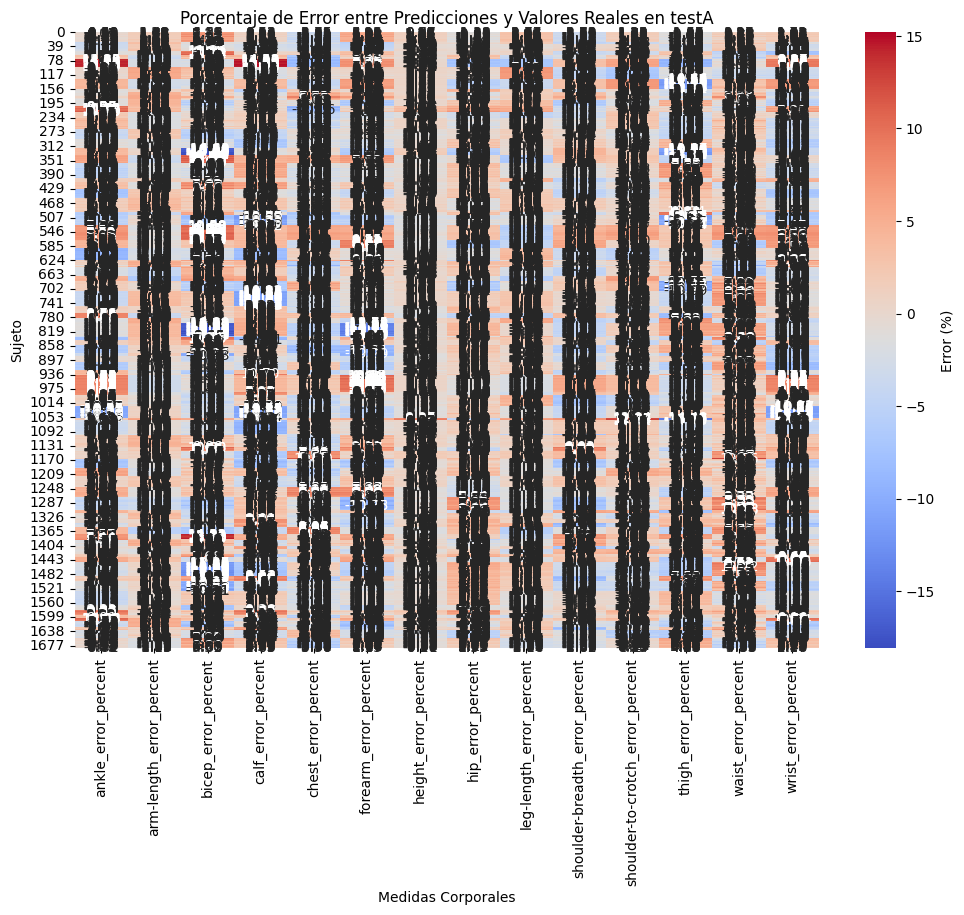

In [23]:
# Seleccionar solo las columnas de porcentaje de error
error_columns = [col for col in comparison_df.columns if '_error_percent' in col]
error_df = comparison_df[error_columns]

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(error_df, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Error (%)'})
plt.title("Porcentaje de Error entre Predicciones y Valores Reales en testA")
plt.xlabel("Medidas Corporales")
plt.ylabel("Sujeto")
plt.show()

<Axes: >

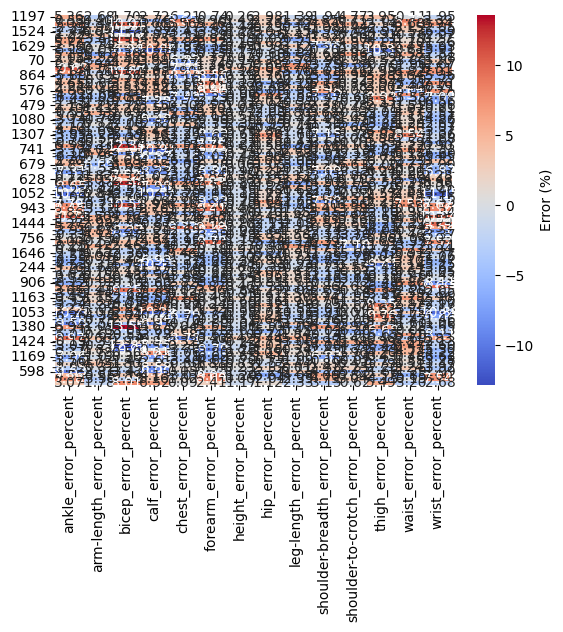

In [24]:
sample_comparison_df = comparison_df.sample(100, random_state=42)  # Tomar una muestra de 100 sujetos
sns.heatmap(sample_comparison_df[error_columns], annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Error (%)'})

<Axes: >

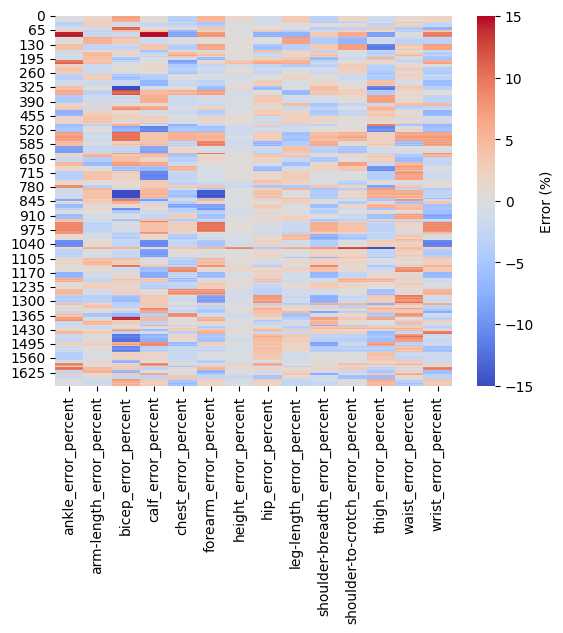

In [25]:
sns.heatmap(error_df, annot=False, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Error (%)'}, vmin=-15, vmax=15)

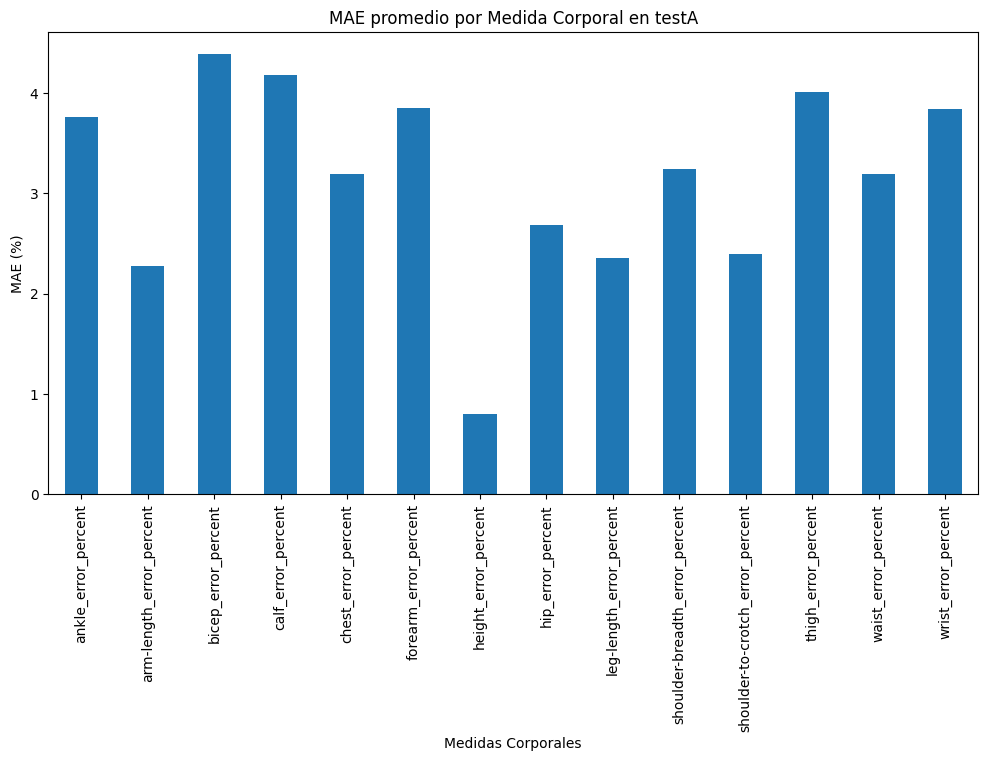

In [26]:
# Calcular el MAE promedio para cada medida
mae = error_df.abs().mean()

plt.figure(figsize=(12, 6))
mae.plot(kind='bar')
plt.xlabel("Medidas Corporales")
plt.ylabel("MAE (%)")
plt.title("MAE promedio por Medida Corporal en testA")
plt.show()

In [27]:
import numpy as np
import pandas as pd

# Suponiendo que `comparison_df` ya contiene los valores reales y predichos de cada medida
# Definimos una tolerancia del 10% (esto se puede ajustar según tus necesidades)
tolerance = 0.10

# Calcular el accuracy por cada medida, considerando como "correcto" un error menor al 10%
accuracy_results = {}
for column in ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'height', 'hip',
               'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']:
    real_col = f"{column}_real"
    pred_col = f"{column}_pred"
    # Calcular el error relativo
    relative_error = abs((comparison_df[pred_col] - comparison_df[real_col]) / comparison_df[real_col])
    # Calcular el accuracy basado en la tolerancia
    accuracy_results[column] = (relative_error <= tolerance).mean() * 100  # Porcentaje de aciertos dentro de la tolerancia

# Accuracy promedio de todas las medidas
average_accuracy = np.mean(list(accuracy_results.values()))
print("Accuracy promedio:", average_accuracy)
print("Accuracy por medida:", accuracy_results)

Accuracy promedio: 97.5738038683407
Accuracy por medida: {'ankle': 95.96199524940617, 'arm-length': 100.0, 'bicep': 88.77672209026129, 'calf': 92.75534441805226, 'chest': 99.8812351543943, 'forearm': 96.49643705463184, 'height': 100.0, 'hip': 100.0, 'leg-length': 100.0, 'shoulder-breadth': 100.0, 'shoulder-to-crotch': 99.58432304038006, 'thigh': 94.95249406175772, 'waist': 99.7624703087886, 'wrist': 97.8622327790974}


In [28]:
# Calcular la media y desviación estándar del error relativo para cada medida
error_deviation = {}
for column in ['ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 'height', 'hip',
               'leg-length', 'shoulder-breadth', 'shoulder-to-crotch', 'thigh', 'waist', 'wrist']:
    real_col = f"{column}_real"
    pred_col = f"{column}_pred"
    # Calcular el error relativo
    relative_error = abs((comparison_df[pred_col] - comparison_df[real_col]) / comparison_df[real_col])
    # Calcular media y desviación estándar
    error_mean = relative_error.mean()
    error_std = relative_error.std()
    # Contar cuántos valores están fuera de 1 desviación estándar
    outliers_1std = (relative_error > (error_mean + error_std)).sum()
    outliers_2std = (relative_error > (error_mean + 2 * error_std)).sum()

    error_deviation[column] = {
        "Error Medio (%)": error_mean * 100,
        "Desviación Estándar (%)": error_std * 100,
        "Fuera de 1 STD": outliers_1std,
        "Fuera de 2 STD": outliers_2std
    }

# Convertir los resultados a un DataFrame para una visualización más clara
error_deviation_df = pd.DataFrame(error_deviation).T
print(error_deviation_df)

                    Error Medio (%)  Desviación Estándar (%)  Fuera de 1 STD  \
ankle                      3.766486                 2.986705           289.0   
arm-length                 2.271009                 1.617126           337.0   
bicep                      4.390473                 3.880681           238.0   
calf                       4.184522                 3.128523           281.0   
chest                      3.194631                 2.270779           272.0   
forearm                    3.853855                 3.081255           255.0   
height                     0.793597                 0.782271           159.0   
hip                        2.679316                 1.846755           281.0   
leg-length                 2.358542                 1.799603           296.0   
shoulder-breadth           3.238887                 2.151739           291.0   
shoulder-to-crotch         2.393794                 2.002773           269.0   
thigh                      4.013306     